# Web Scraping Amazon

## Yinghong Xu

In [2]:
ipython nbconvert to HTML your_notebook.ipynb

SyntaxError: invalid syntax (<ipython-input-2-219163a83d1d>, line 1)

In [123]:
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq
import pandas as pd
import numpy as np

In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [110]:
# my_url='https://www.amazon.com/Best-Sellers-Sports-Outdoors/zgbs/sporting-goods/ref=zg_bs_pg_1?_encoding=UTF8&pg=1'

# uClient=uReq(my_url)
# page_html=uClient.read()
# uClient.close()
# page_soup=soup(page_html, "html.parser")
# containers = page_soup.findAll("span", {"class":"aok-inline-block zg-item"
# price=page_soup.findAll("span", {"class":"p13n-sc-price"})[1]

# Generate Data from Amazon
products={}
prd_no=0

urls=[]
for page in range(3):
    urls.append('https://www.amazon.com/Best-Sellers-Sports-Outdoors/zgbs/sporting-goods/ref=zg_bs_pg_{}?_encoding=UTF8&pg={}'.format(page, page))
page=urls[1:]

for p in page:
    uClient=uReq(p)
    page_html=uClient.read()
    uClient.close()
    page_soup=soup(page_html, "html.parser")
    containers= page_soup.findAll("div",{"class":"a-section a-spacing-none aok-relative"})
         
    for container in containers:
        #product_name=container.div.img["alt"].replace("," , "|")
        
        product_name=container.findAll("div", {"class": "a-section a-spacing-small"})[0].img["alt"]
        link_container=container.findAll("a", {"class":"a-link-normal"})[0]["href"]
        preflix="https://www.amazon.com"
        link=preflix+link_container
        
        #price
        if container.findAll("span", {"class":"p13n-sc-price"}):
            price=container.findAll("span", {"class":"p13n-sc-price"})[0].text
        else:
            price=""
            
        #rating
        if container.findAll("span", {"class":"a-icon-alt"}):
            rating=container.findAll("span", {"class":"a-icon-alt"})[0].text
        else:
            rating=""

        #reviews
        if container.findAll("a", {"class":"a-size-small a-link-normal"}):
            reviews=container.findAll("a", {"class":"a-size-small a-link-normal"})[0].text
        else:
            reviews=""
            
        #rank
        rank=container.findAll("span", {"class":"zg-badge-text"})[0].text
        
        prd_no+=1
        products[prd_no]=[product_name, rank, link, price, rating, reviews]
#         print("Product name: "+product_name)
#         print("Product link: "+ link)
#         print("price: "+ price)
#         print("Rating: "+rating)
#         print("Reviews:"+reviews)
   
print(products[1])


['Unisex Face Shield, Black (Pack of 8 w/ 45 Filters)', '#1', 'https://www.amazon.com/Washable-Protective-seilliet-Reusable-Breathable/dp/B086R68WWQ?_encoding=UTF8&psc=1', '', '', '']


In [111]:
prd_no

100

In [115]:
products_df=pd.DataFrame.from_dict(products, orient='index', columns=['product_name', 'rank', 'link', 'price', 'rating', 'reviews'])
products_df.head()

,product_name,rank,link,price,rating,reviews
1,"Unisex Face Shield, Black (Pack of 8 w/ 45 Fil...",#1,https://www.amazon.com/Washable-Protective-sei...,,,
2,"Letsfit Resistance Loop Bands, Resistance Exer...",#2,https://www.amazon.com/Letsfit-Resistance-Exer...,$17.85,4.5 out of 5 stars,"7,743"
3,CoolBELL Mouth Protective 3-Ply Wearing Face C...,#3,https://www.amazon.com/CoolBELL-Protective-Wea...,$9.99,,
4,Fit Simplify Resistance Loop Exercise Bands wi...,#4,https://www.amazon.com/Fit-Simplify-Resistance...,$17.85,4.3 out of 5 stars,"17,298"
5,Gaiam Essentials Premium Yoga Mat with Yoga Ma...,#5,https://www.amazon.com/Gaiam-Essentials-Premiu...,$20.28,4.6 out of 5 stars,"1,086"


In [116]:
products_df.to_csv('prds.csv')

In [117]:
import findspark
findspark.init()

In [118]:
from pyspark.sql import SparkSession
ss = SparkSession.builder.master("local") .appName("Word Count") .getOrCreate()

In [119]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt

In [125]:
df=pd.read_csv('prds.csv')

In [130]:
# Clean data

df['rank']=df['rank'].str.strip('#')
df.price=df.price.str.strip('$')

tdf=df.rating.str.split(' ', expand=True)[0]
df.rating=tdf

tdf=df.link.str.split('/', expand=True)[3]
df['name']=tdf

#df.head()

df1=df.drop('link', axis=1)


df1['name']=df1['name'].str.lower().str.replace('-',' ')
df1['name']=df1['name'].str.replace('%',' ')

# sdf=ss.createDataFrame(df[['']])
# sdf.head()

# df1.to_csv('df1.csv')
df1.head()

,Unnamed: 0,product_name,rank,price,rating,reviews,name
0,1,"Unisex Face Shield, Black (Pack of 8 w/ 45 Fil...",1,NaN,NaN,NaN,washable protective seilliet reusable breathable
1,2,"Letsfit Resistance Loop Bands, Resistance Exer...",2,17.85,4.5,"7,743",letsfit resistance exercise stretching strength
2,3,CoolBELL Mouth Protective 3-Ply Wearing Face C...,3,9.99,NaN,NaN,coolbell protective wearing comfortable breathing
3,4,Fit Simplify Resistance Loop Exercise Bands wi...,4,17.85,4.3,"17,298",fit simplify resistance exercise instruction
4,5,Gaiam Essentials Premium Yoga Mat with Yoga Ma...,5,20.28,4.6,"1,086",gaiam essentials premium carrier sling


In [132]:
sdf=ss.createDataFrame(df1[['rank','name']])
sdf.head()

Row(rank='1', name='washable protective seilliet reusable breathable')

In [133]:
tokenizer = Tokenizer(inputCol="name", outputCol="words")
vectorizer = CountVectorizer(inputCol="words", outputCol="rawFeatures")

In [134]:
pipeline = Pipeline(stages=[tokenizer, vectorizer])

model = pipeline.fit(sdf)

In [135]:
t_vectors = model.transform(sdf)
t_vectors.show(5)

+----+--------------------+--------------------+--------------------+
|rank|                name|               words|         rawFeatures|
+----+--------------------+--------------------+--------------------+
|   1|washable protecti...|[washable, protec...|(334,[50,75,217,2...|
|   2|letsfit resistanc...|[letsfit, resista...|(334,[0,1,44,173,...|
|   3|coolbell protecti...|[coolbell, protec...|(334,[50,114,127,...|
|   4|fit simplify resi...|[fit, simplify, r...|(334,[0,1,74,143,...|
|   5|gaiam essentials ...|[gaiam, essential...|(334,[22,33,35,18...|
+----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [136]:
sparce_vectors=t_vectors.select('rawFeatures').rdd\
.map(lambda row: row['rawFeatures'].toArray()) #\
sparce_vectors.take(1)[0].shape

(334,)

In [137]:
total_counts=sparce_vectors.reduce(lambda x,y: [x[i]+y[i] for i in range(len(y))])
vocabList = model.stages[1].vocabulary
d = {'vocabList':vocabList,'counts':total_counts}

In [135]:
# Pyspark word counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

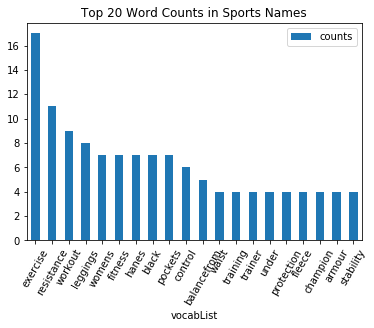

In [138]:
ddf=pd.DataFrame(d).set_index('vocabList') 
# my_colors = 'rgbkymc'
ddf.head(20).plot(kind='bar')
plt.title("Top 20 Word Counts in Sports Names")
plt.xticks(rotation=60)

In [142]:
#clean data
df_new=df1.dropna(axis='rows')

df_new.reviews=df_new.reviews.str.replace(',', '')
df_new['reviews'] = df_new['reviews'].astype(int)
df_new['price'] = pd.to_numeric(df_new['price'])
df_new['rank'] = pd.to_numeric(df_new['rank'])
df_new['rating'] = pd.to_numeric(df_new['rating'])

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

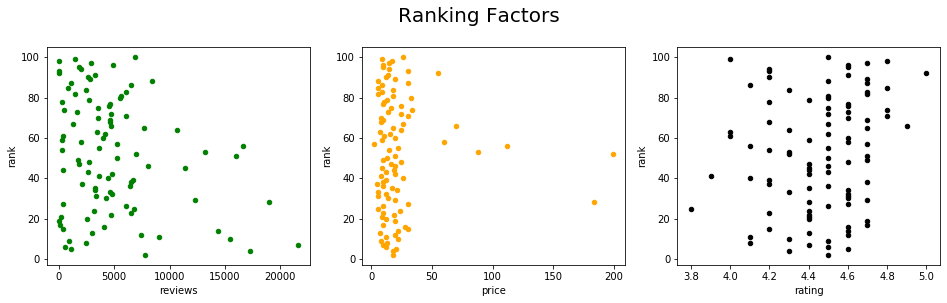

In [143]:
#plt.figure(figsize=(16, 8))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
fig.suptitle('Ranking Factors', size=20, y=1.02)

df_new.plot(x='price', y='rank', kind='scatter', color='orange', ax=ax2)
df_new.plot(x='reviews', y='rank', kind='scatter', color='green', ax=ax1)
df_new.plot(x='rating',y='rank', kind='scatter', color='black', ax=ax3)

In [152]:
X = df_new[['rating', 'price','reviews']]
y = df_new['rank']
# reg = LinearRegression()
# reg.fit(X, y)
# reg.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

print('Training Data Count: {}'.format(X_train.shape[0]))
print('Testing Data Count: {}'.format(X_test.shape[0]))

Training Data Count: 87
Testing Data Count: 10


In [154]:
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     3.537
Date:                Wed, 15 Apr 2020   Prob (F-statistic):             0.0182
Time:                        22:29:00   Log-Likelihood:                -409.96
No. Observations:                  87   AIC:                             827.9
Df Residuals:                      83   BIC:                             837.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -64.7288     59.547     -1.087      0.2

In [146]:
X = np.column_stack((df_new['reviews'], df_new['price'], df_new['rating']))
y = df_new['rank']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     3.496
Date:                Wed, 15 Apr 2020   Prob (F-statistic):             0.0187
Time:                        21:36:57   Log-Likelihood:                -456.53
No. Observations:                  97   AIC:                             921.1
Df Residuals:                      93   BIC:                             931.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.5558     54.897     -0.356      0.7